# <center> VAI Store - Análise Exploratória de Dados </center>

---

Nesse jupyter notebook iremos analisar os dados de produtos e vendas da VAI Store

## 1. Imports

In [315]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import importlib

In [316]:
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd().parent / 'src' / 'plots'))
sys.path.insert(0, str(Path.cwd().parent / 'src' / 'utils'))

## 2. Dataset

In [317]:
produtos = pd.read_csv('../data/raw/produto.csv', index_col = 0)

# Leitura dos dados
produtos.info()
produtos.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 3.0 to nan
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   NOME_PRODUTO  6499 non-null   object
 1   CATEGORIA     4498 non-null   object
 2   SUBCATEGORIA  4498 non-null   object
dtypes: object(3)
memory usage: 203.1+ KB


,NOME_PRODUTO,CATEGORIA,SUBCATEGORIA
SKU,,,
3.0,COCO RALADO GROSSO KG ...,Doceria,Confeitaria
4.0,ICE TEA LEAO LATA 340ML ...,NaN,NaN
5.0,TAHINE ISTAMBUL 200G ...,Pelo Mundo,Pastas Árabes
6.0,AMENDOIM MOIDO KG ...,Castanhas & Oleaginosas,Oleaginosas moídas
7.0,HALAWI ISTAMBUL LATA 500G ...,Pelo Mundo,Pastas Árabes


Sumário das colunas:
* SKU = Código do produto 
* NOME_PRODUTO = Descrição do produto 
* CATEGORIA = Categoria do produto 
* SUBCATEGORIA = Subcategoria do produto

In [318]:
vendas = pd.read_csv('../data/raw/vendas.csv', index_col = 0)

# Leitura dos dados
vendas.info()
vendas.head()

<class 'pandas.core.frame.DataFrame'>
Index: 556198 entries, 000304564.299.0101042.20240102 to 000503479.257.0101032.20241231
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   COD_VENDA    556198 non-null  object 
 1   COD_FILIAL   556198 non-null  int64  
 2   FILIAL       556198 non-null  object 
 3   DATA_ATEND   556198 non-null  object 
 4   SKU          556198 non-null  int64  
 5   UNID         556198 non-null  object 
 6   QTD_VENDA    556198 non-null  float64
 7   FATUR_VENDA  556198 non-null  float64
 8   CLI_CPF      556198 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 42.4+ MB


,COD_VENDA,COD_FILIAL,FILIAL,DATA_ATEND,SKU,UNID,QTD_VENDA,FATUR_VENDA,CLI_CPF
COD_ATEND,,,,,,,,,
000304564.299.0101042.20240102,000304564.299.0101042.20240102.000009.02,101042,SHOPPING,2024-01-02,9,KG,0.258,18.04,ec0abf3f4220
000374698.258.0101032.20240102,000374698.258.0101032.20240102.000009.10,101032,RUA,2024-01-02,9,KG,0.064,4.50,83d596ee0acf
000383551.256.0101032.20240102,000383551.256.0101032.20240102.000009.02,101032,RUA,2024-01-02,9,KG,0.164,11.49,46f63c18e055
000383533.256.0101032.20240102,000383533.256.0101032.20240102.000009.02,101032,RUA,2024-01-02,9,KG,0.202,14.13,6def1d35e2fe
000432095.257.0101032.20240102,000432095.257.0101032.20240102.000051.06,101032,RUA,2024-01-02,51,KG,0.086,6.87,1576e1a36394


Sumário das colunas:
* COD_ATEND = Código identificador do atendimento 
* COD_VENDA = Código identificador da venda 
* COD_FILIAL = Indica em qual loja foi feito o atendimento 
* FILIAL = Tipo de filial (Loja de Rua ou de Shopping) 
* DATA_ATEND = Data de atendimento daquele cliente a respeito daquele produto 
* SKU = Código do produto 
* UNID = Indica tipo do produto (granel ou prateleira) 
* QTD_VENDA = Quantidade vendida do produto 
* FATUR_VENDA  = Faturamento 
* CLI_CPF = Código do cliente

In [319]:
produtos.shape

(6500, 3)

## 3. Tratamento

### 3.1. Tratamento de valores ausentes

In [320]:
vendas.isna().sum()

COD_VENDA      0
COD_FILIAL     0
FILIAL         0
DATA_ATEND     0
SKU            0
UNID           0
QTD_VENDA      0
FATUR_VENDA    0
CLI_CPF        0
dtype: int64

In [321]:
produtos.isna().sum()

NOME_PRODUTO       1
CATEGORIA       2002
SUBCATEGORIA    2002
dtype: int64

Observa-se que, no dataset de **produtos**, há a presença de valores nulos em todas as colunas. Sendo assim, vamos analisar caso a caso.

#### 3.1.1. CATEGORIA e SUBCATEGORIA

Para essas colunas categóricas, vamos substituir os valores ausentes por um novo tipo: **'Sem categoria'** e **'Sem subcategoria'**.

In [322]:
produtos['CATEGORIA'] = produtos['CATEGORIA'].fillna('Sem categoria')
produtos['SUBCATEGORIA'] = produtos['SUBCATEGORIA'].fillna('Sem subcategoria')

#### 3.1.2. NOME_PRODUTO

In [323]:
produtos[produtos['NOME_PRODUTO'].isna()]

,NOME_PRODUTO,CATEGORIA,SUBCATEGORIA
SKU,,,
NaN,NaN,Sem categoria,Sem subcategoria


Nesse caso, a linha é constituída apenas de valores nulos e, além disso, não há a possibilidade desse produto ter um relacionamento com alguma venda. Sendo assim, vamos simplesmente **remover** essa observação.

In [324]:
produtos.dropna(inplace=True)

In [325]:
# Quantidade de valores nulos pós tratamento
produtos.isna().sum()

NOME_PRODUTO    0
CATEGORIA       0
SUBCATEGORIA    0
dtype: int64

### 3.2. Conversão dos tipos de dados

In [326]:
# Conversão de COD_FILIAL e SKU (vendas) para str
vendas['COD_FILIAL'] = vendas['COD_FILIAL'].astype(str)
vendas['SKU'] = vendas['SKU'].astype(str)

# Conversão de SKU (produtos) para str
produtos.index = produtos.index.astype(int).astype(str)

# Conversão de DATA_ATEND para 'date'
vendas['DATA_ATEND'] = pd.to_datetime(vendas['DATA_ATEND'])

### 3.3. Limpeza de strings

Na coluna NOME_PRODUTO, os valores possuem espaços em branco após o último caracter. Por isso, vamos remover essas lacunas.

In [327]:
produtos['NOME_PRODUTO'] = produtos['NOME_PRODUTO'].str.strip()

In [328]:
# Nome dos produtos após tratamento
produtos['NOME_PRODUTO']

SKU
3                                     COCO RALADO GROSSO KG
4                                   ICE TEA LEAO LATA 340ML
5                                      TAHINE ISTAMBUL 200G
6                                         AMENDOIM MOIDO KG
7                                 HALAWI ISTAMBUL LATA 500G
                                ...                        
171803     CREME DE LEITE DOCE ECILA 35% GARRAFA 450G 30261
171874                       BARRA BOLD BAR BANOFFEE 60G NV
171877    VINHO CASIL.D.CARNAVAL SPECTACULAR CARBENET 75...
171878    VINHO CASIL.D.CARNAVAL FANTASTIC SWEET 750ML C...
171887                BATATA PALHA EXTRA FINA VISCONTI 100G
Name: NOME_PRODUTO, Length: 6499, dtype: object

## 4. EDA

### 4.1. Análise do desempenho de vendas e faturamento

Primeiro, vamos fazer a análise exploratória dos dados voltado para as **vendas** e **faturamento**. Podemos começar entendendo o faturamento total e a variação dele ao longo dos meses de 2024.

In [329]:
# Importação das funções de plotagem
import plot_faturamento_filial as pff
import plots_faturamento as pf

# Atualização dos módulos na cache
importlib.reload(pff);
importlib.reload(pf);

In [330]:
vendas_2024 = vendas.loc[vendas['DATA_ATEND'].dt.year == 2024]

faturamento = vendas_2024['FATUR_VENDA'].sum()

faturamento_formatado = f"R$ {faturamento:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
print(f"Faturamento Total de 2024: {faturamento_formatado}")

Faturamento Total de 2024: R$ 7.848.726,93


Agora que vimos que o **faturamento total** de 2024 é de R$ 7.848.726,93, podemos analisar a distribuição desse faturamento pelos **meses do ano**.

/home/dinux/projects/projeto-final/Grupo6-ProjetoFinal/src/plots/plots_faturamento.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


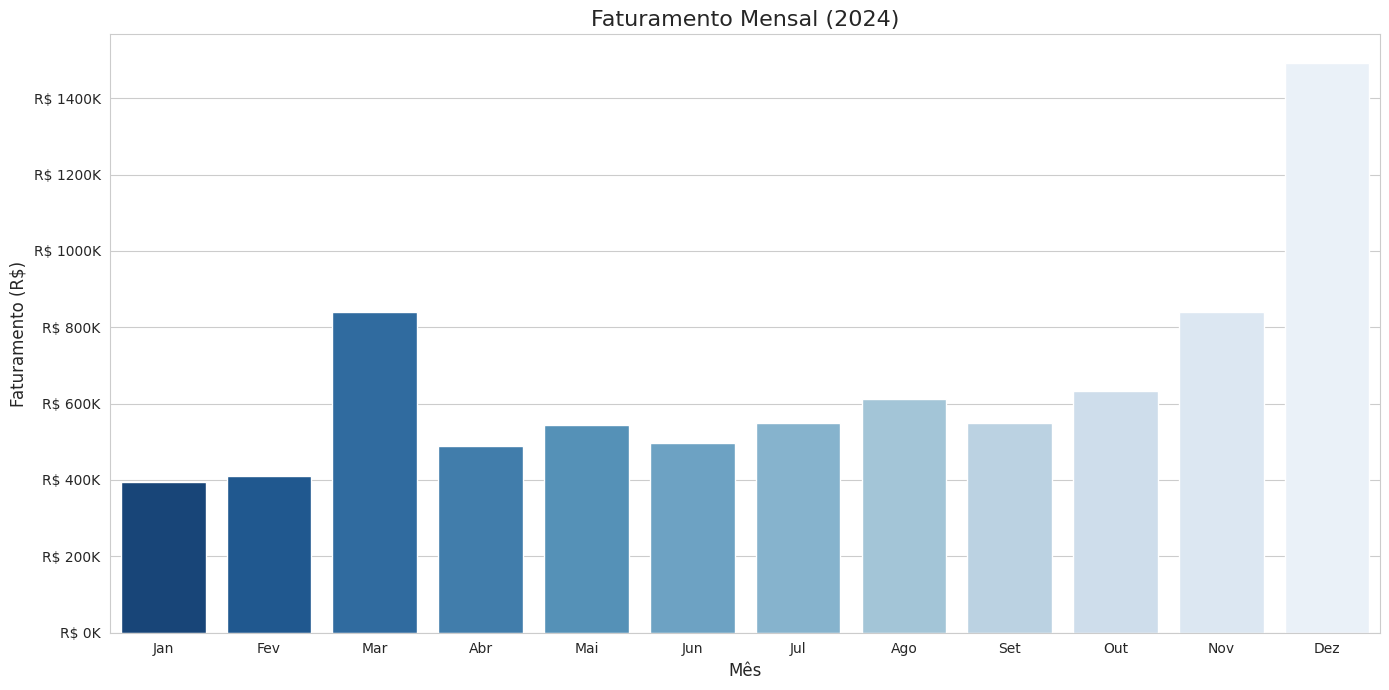

In [331]:
pf.faturamento_mensal(vendas)

A análise do faturamento mensal revela uma pequena divergência de faturamento mês a mês. Porém, observa-se que os meses de março, novembro e dezembro se destacam como possíveis __outliers__. Sendo assim, vamos criar um array com seus respectivos índices para manipular esses outliers posteriormente.

In [332]:
meses_outliers = [3, 11, 12]

#### Análise do faturamento por filiais

Agora, vamos analisar a distribuição do faturamento total da loja entre suas **filiais**.

/home/dinux/projects/projeto-final/Grupo6-ProjetoFinal/src/plots/plot_faturamento_filial.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


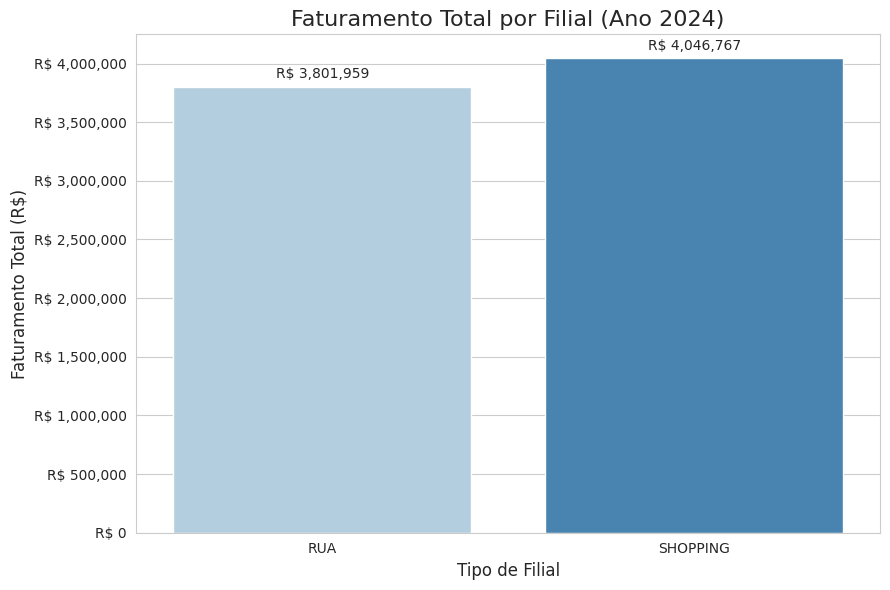

In [333]:
pff.plot_faturamento_total_filial(vendas)

Fica perceptível que há uma **diferença de faturamento** entre as filiais, então vamos destrinchar essa receita um pouco mais para chegar no **fator motor dessa discrepância**.

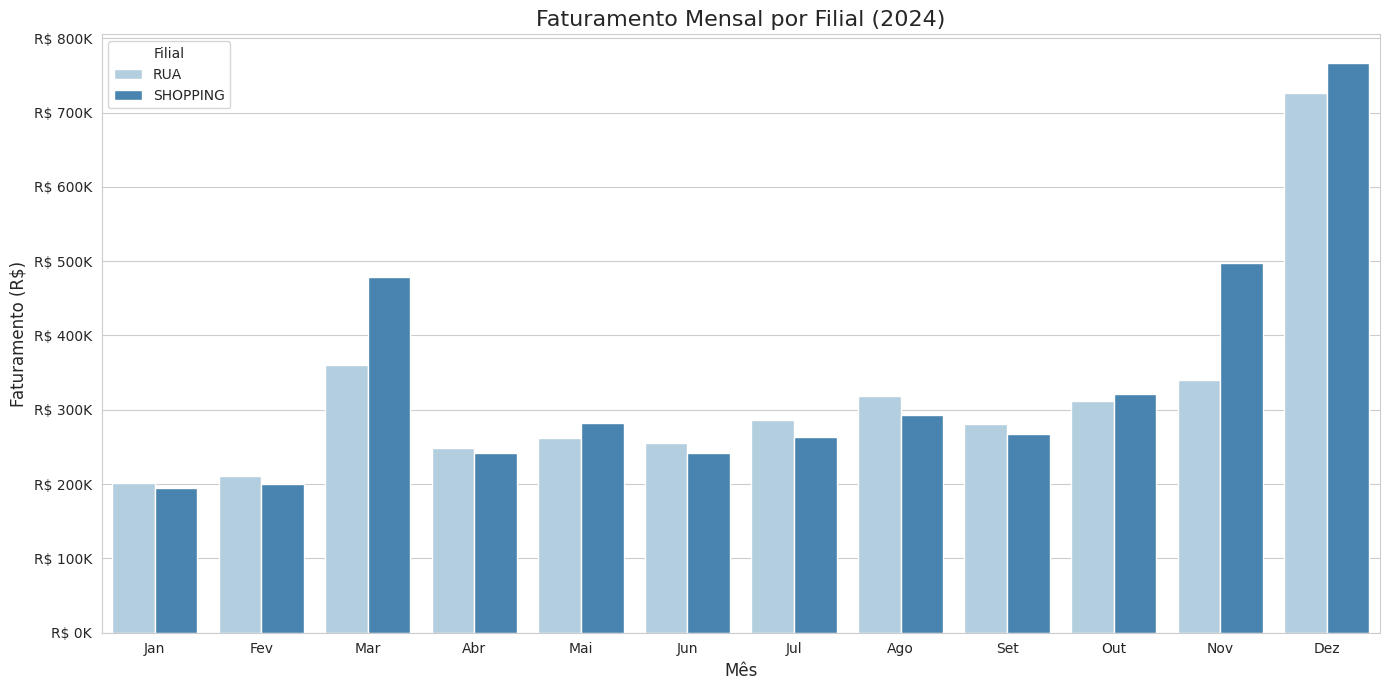

In [334]:
pff.plot_faturamento_mensal_filial(vendas)

Podemos ver claramente que os meses que moveram a diferença de faturamento entre as filiais foram, novamente, os outliers observados anteriormente (março, novembro e dezembro). Será que nesses meses houve uma **diferença no ticket médio** do cliente que **influênciou a divergência de receita**?

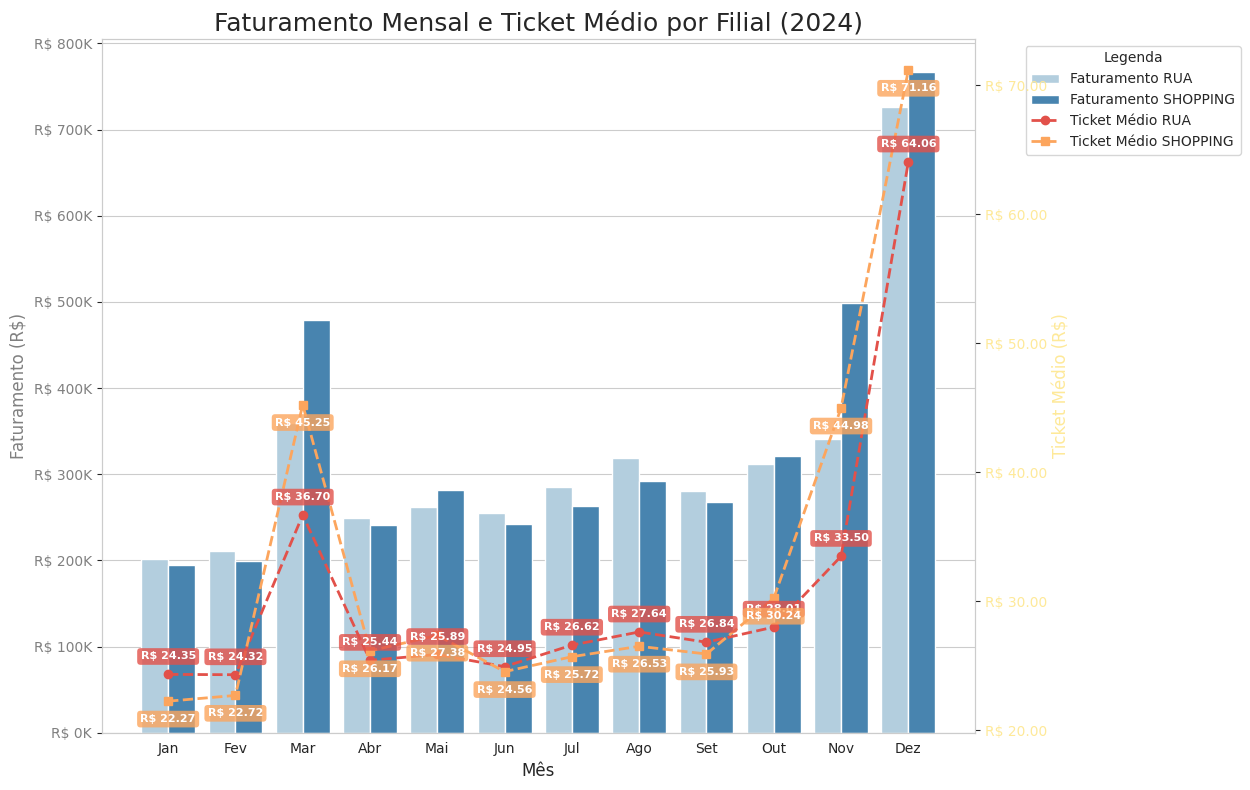

In [335]:
pff.plot_faturamento_e_ticket_medio_mensal(vendas)

Podemos ver no gráfico acima que o **faturamento** da loja está **correlacionado ao seu ticket médio** e, justamente nos meses que o faturamento do Shopping foi bem maior que o faturamento da Rua, o ticket médio entre as filiais foi mais discrepante. Por isso, queremos entender quais são os fatores que movem essa diferença de ticket médio.

Primeiro, vamos ver se todas as compras registradas tem o CPF do cliente comprador associado ao produto vendido

In [336]:
nan_count_CPF = vendas['CLI_CPF'].isna().sum()
print(f"Número de valores ausentes na coluna 'CLI_CPF': {nan_count_CPF}")

Número de valores ausentes na coluna 'CLI_CPF': 0


Logo, já que todas as vendas estão associadas a um CPF, podemos extrair o **número de clientes únicos** ao longo dos meses. 

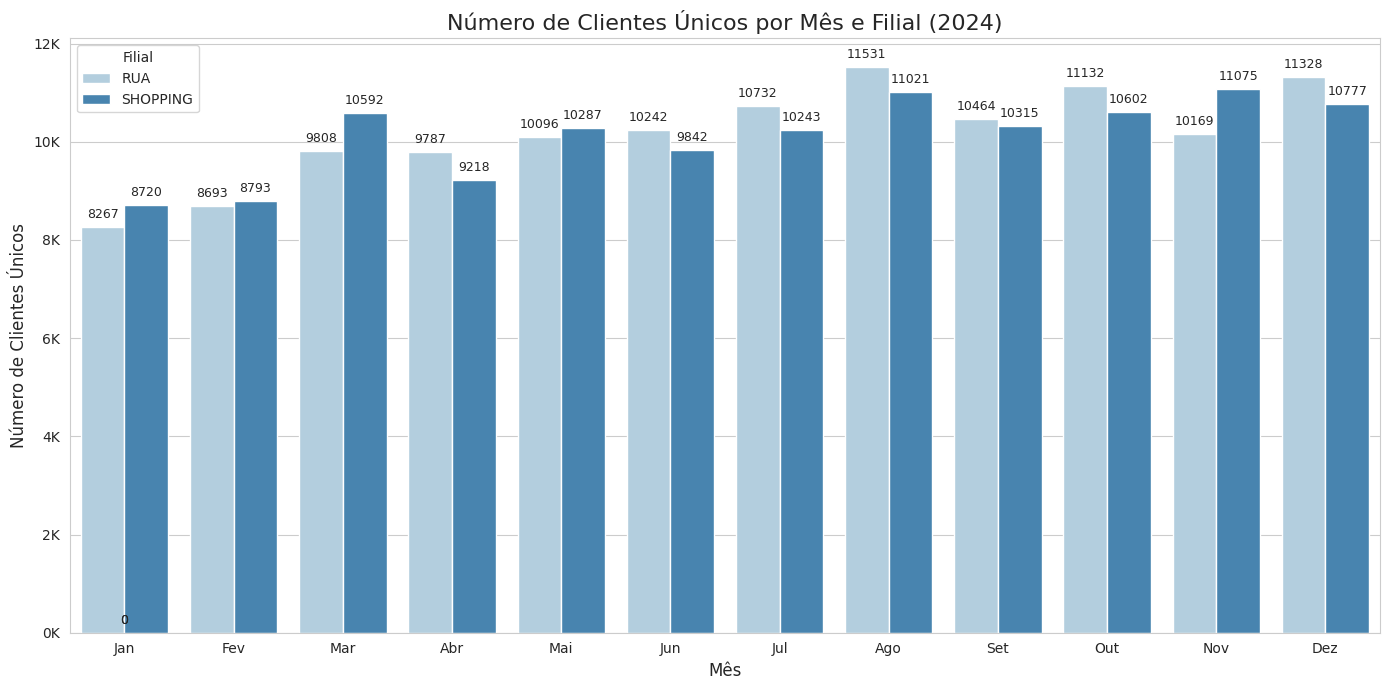

In [337]:
pff.plot_clientes_unicos_mensal_filial(vendas)

Com o número de clientes únicos por loja, podemos ver que **normalmente não há uma grande diferença entre cada filial**. Contudo, os meses de março e novembro foram contra essa máxima, tendo **mais público comprando na loja do Shopping** do que na loja da Rua, talvez sendo um dos fatores que moveu a diferença do faturamento entre as filiais nesses meses. Mesmo assim, vemos que, no mês de dezembro, o ponto de venda da Rua apresentou uma maior clientela. Portanto, o **maior faturamento do Shopping não está conectado com essa variável, mas sim com o ticket médio do cliente**.

Diante das análises acima, o **principal achado** é que os **meses de marços, novembro e dezembro** podem atuar como **possíveis outliers**. Sendo assim, a partir de uma análise aprofundada dos produtos, queremos entender se essa observação é confirmada.

### 4.2. Análise do catálogo de produtos

Neste momento, vamos entender quais as **principais categorias ofertadas** pela VAI Store.

In [338]:
# Importação das funções de plotagem
import plots_catalogo_produtos as pc

importlib.reload(pc);

/home/dinux/projects/projeto-final/Grupo6-ProjetoFinal/src/plots/plots_catalogo_produtos.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


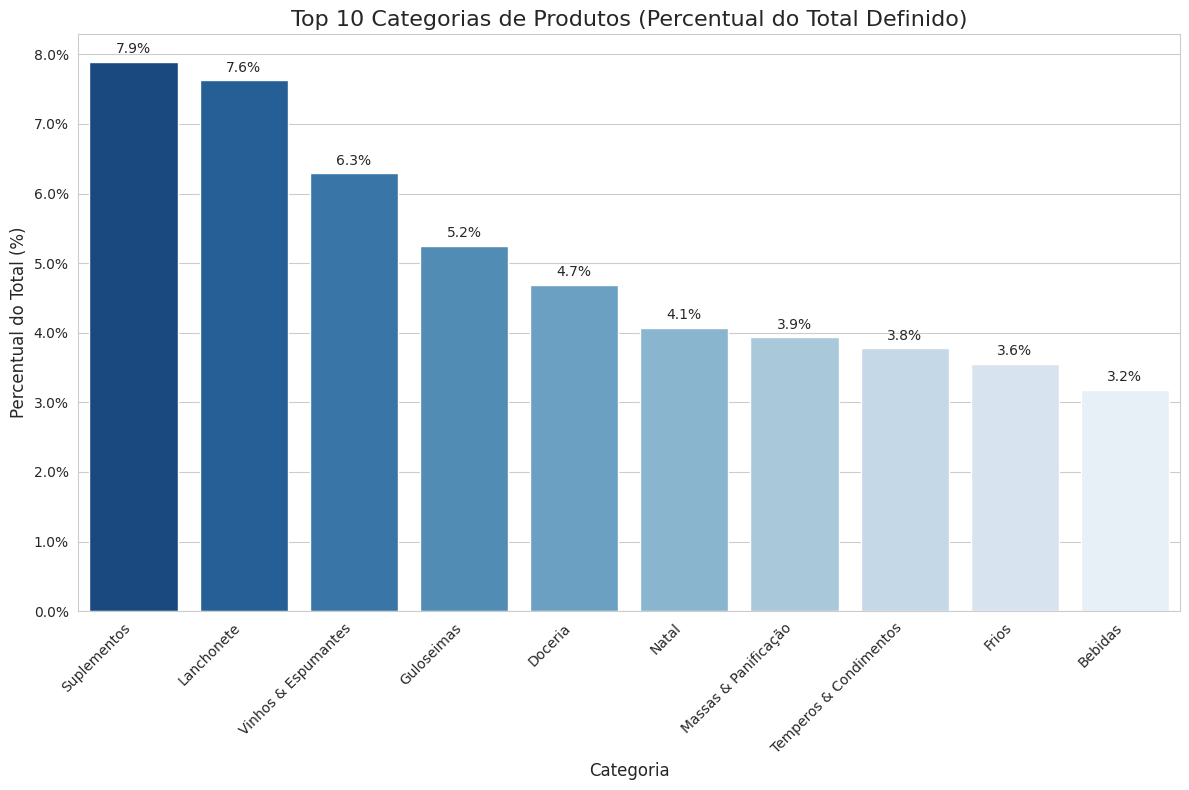

In [339]:
pc.plot_top_10_categorias(produtos)

Após conhecer as principais categorias de produtos, analisaremos as **principais subcategorias**.

/home/dinux/projects/projeto-final/Grupo6-ProjetoFinal/src/plots/plots_catalogo_produtos.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


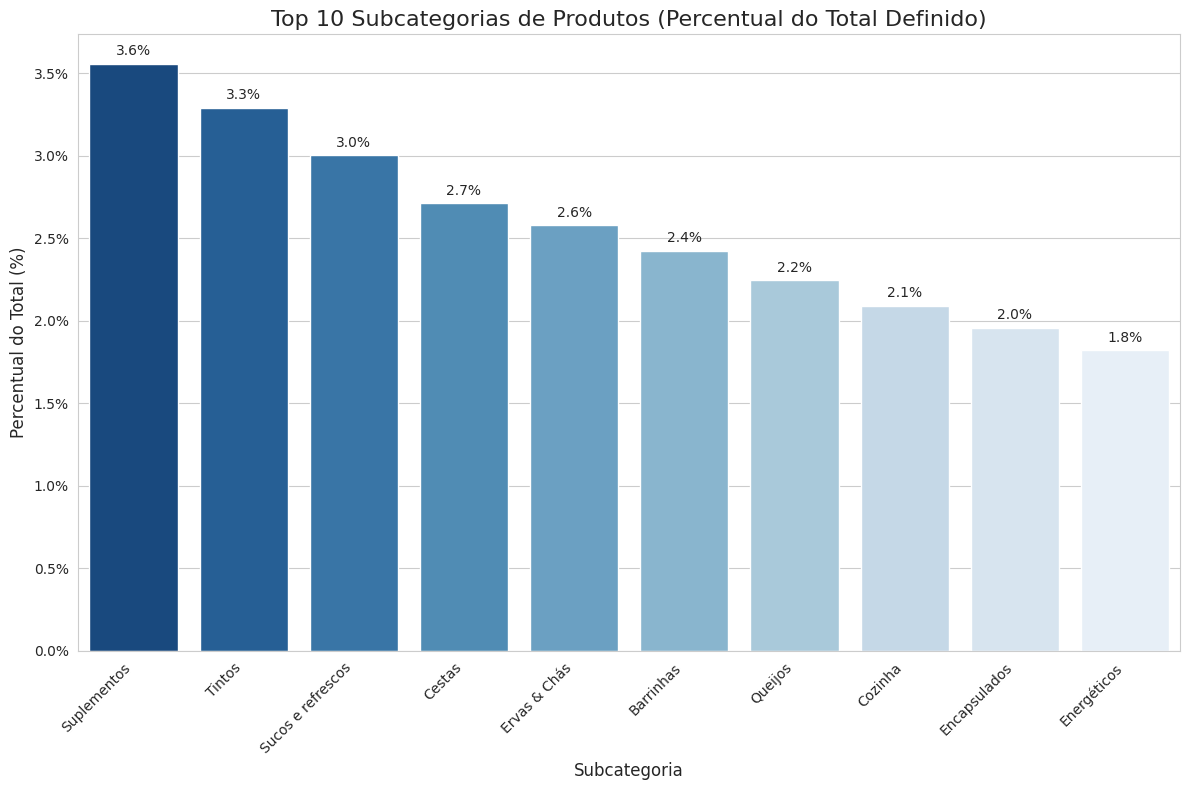

In [340]:
pc.plot_top_10_subcategorias(produtos)

Diante as informações acima podemos entender como o **_pool_ de produtos** da VAI Store está estruturado atualmente

### 4.3. Análise das vendas de produtos

Agora, vamos entender como o faturamento e quantidade de vendas da loja estão distribuídos entre os produtos e suas categorias/subcategorias. Portanto, vamos plotar os **principais drivers de volume** da VAI Store em 2024.

In [341]:
import plots_produtos as pp
import merge_datasets as md

importlib.reload(md);
importlib.reload(pp);

In [342]:
# Agregando produtos e vendas
df_agg = md.merge_datasets(vendas, produtos, 'SKU')

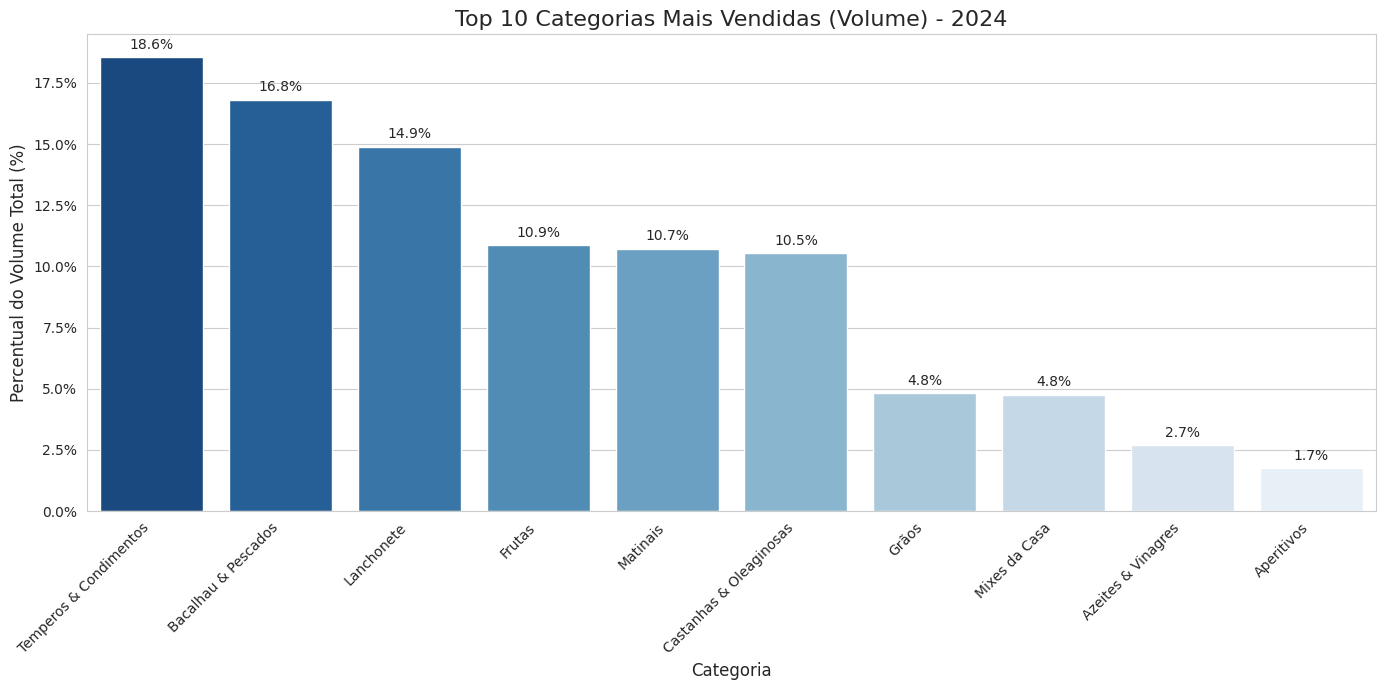

In [343]:
pp.top_categorias_vendidas(df_agg)

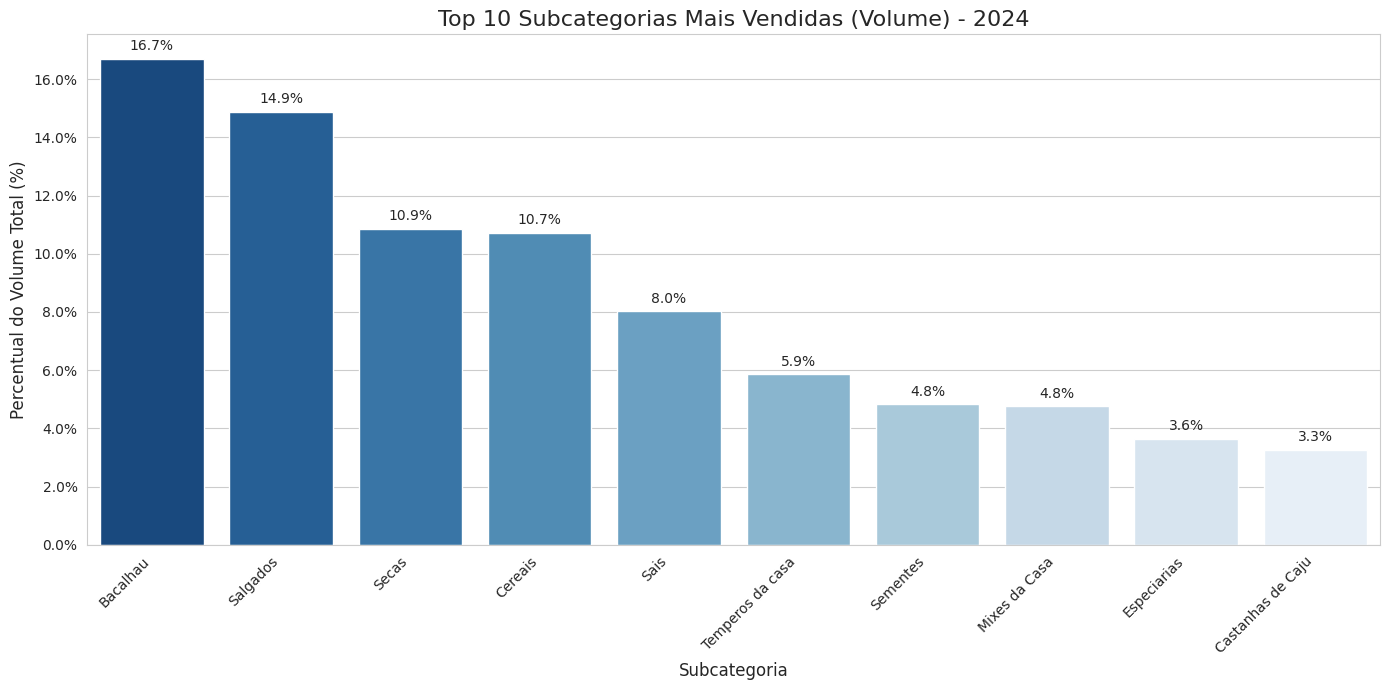

In [344]:
pp.top_subcategorias_vendidas(df_agg)

Ademais, queremos analisar se as principais categorias se configuram como ___drivers___ da receita. 

/home/dinux/projects/projeto-final/Grupo6-ProjetoFinal/src/plots/plots_produtos.py:665: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  data=df_top_categorias,


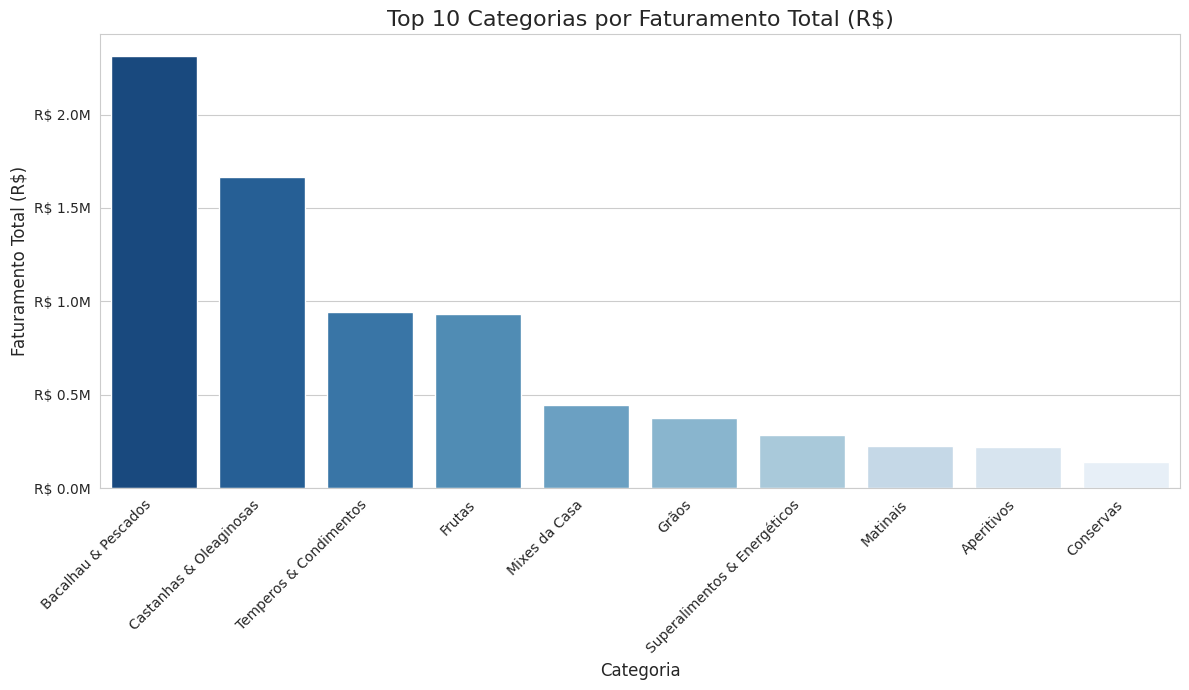

In [345]:
pp.top_categorias_valor(df_agg)

Portanto, é possível observar que, mesmo tendo o segundo maior _share_ do volume de vendas, '**Bacalhau & Pescados**' apresentam o maior faturamento dentre todas as categorias. Isso pode indicar que produtos dessa classe têm um **preço mais elevado**.

Estabelecendo as categorias responsáveis pela maior parte dos volumes das vendas e do faturamento, vamos analisar os principais _drivers_ de cada mês, focando na extração de possíveis **sazonalidades**.

/home/dinux/projects/projeto-final/Grupo6-ProjetoFinal/src/plots/plots_produtos.py:297: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_n_mensal = df_agregado.groupby('MES_NUM', group_keys=False).apply(get_top_n)


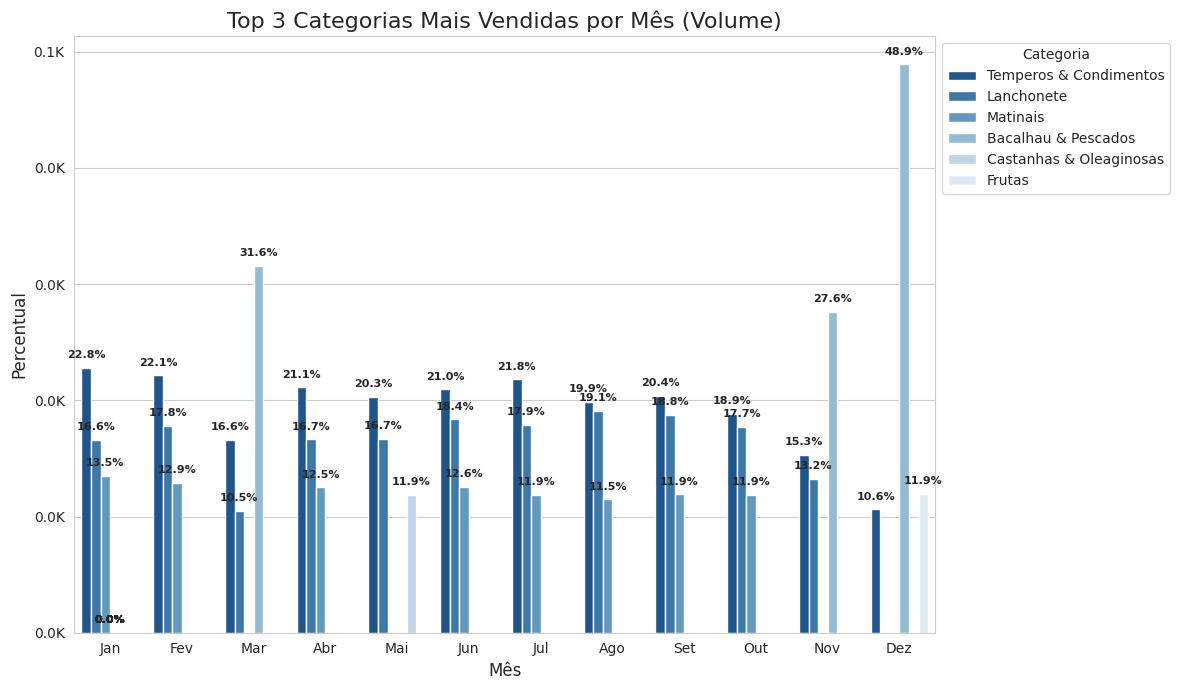

In [346]:
pp.top_categorias_mensal(df_agg, 3)

A partir desse gráfico, conseguimos observar o seguinte:
- A categoria 'Bacalhau & Pescados' (2º maior _share_ do volume de vendas) configura entre o top 3 apenas nos meses _outliers_, indicando forte ligação do consumo com **datas comemorativas** (Páscoa e Natal), e que o estoque e o preço para essas datas são **fatores críticos de risco**
- Além disso, produtos da categoria 'Lanchonete', que atua como um gênero consistente e estável durante a maior parte do ano, não está entre os mais vendidos do mês de Dezembro. Isso confirma que o **padrão de compra do consumidor** muda drasticamente para **itens de festividade**, e o espaço deve ser otimizado em favor dos produtos sazonais.

Sendo assim, vamos validar se 'Bacalhau' é um fenômeno concentrado em tipo de filial ou se ocorre de maneira uniforme. Para isso, analisaremos o percentual do volume vendido da categoria em cada ponto de venda. 

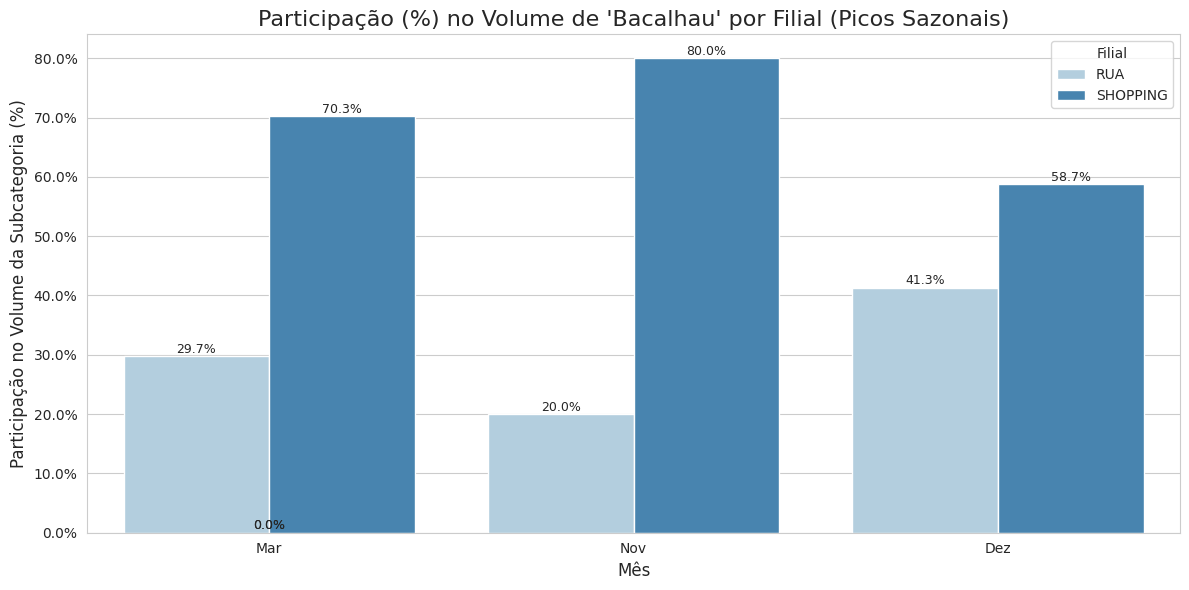

In [347]:
pp.subcategoria_by_filial_sazonal(df_agg, 'Bacalhau')

É notório que o Shopping possui um _share_ de vendas superior. Em paralelo à análise apresentada no tópico 4.1, observa-se que o ponto da Rua apresenta uma desvantagem significativa no faturamento nos meses de março, novembro e dezembro. Nesse contexto, o 'Bacalhau' pode atuar como um **fator crucial** que inflaciona a diferença de faturamento, sendo indispensável a **otimização de estoque** do produto nessas datas.

## 5. Descobertas e Principais Insights das Análises

Com um faturamento total de **R$ 7,85 milhões** em 2024, a análise dos dados revelou padrões de sazonalidade e diferenças operacionais significativas entre as filiais.

**1. Sazonalidade Extrema e Meses Atípicos (Outliers)**

A descoberta mais impactante é a identificação de três meses que fogem completamente ao padrão de faturamento: **Março, Novembro e Dezembro.** Esses meses atuam como _outliers_ e são o principal motor das maiores discrepâncias encontradas nos dados.

**2. O Fator Decisivo: Ticket Médio, Não Número de Clientes**

Ao comparar as filiais de "Rua" e "Shopping", notou-se uma grande diferença de receita, especialmente nos meses atípicos.

* **Refutação de Hipótese:** A causa dessa diferença **não é o número de clientes.** Embora o Shopping tenha tido mais clientes em alguns meses, a loja de Rua teve mais clientes em Dezembro, e mesmo assim faturou menos.

* **Descoberta Principal:** O faturamento está diretamente **correlacionado ao Ticket Médio.** A filial Shopping apresentou um ticket médio muito mais alto justamente nos meses outliers, explicando sua performance superior.

**3. O Produto "Herói" Sazonal: Bacalhau & Pescados**

A análise de produtos confirmou o motivo dos meses atípicos e do aumento do ticket médio:

* **Produto de Alto Valor:** A categoria **'Bacalhau & Pescados'** gera o **maior faturamento** da loja, mesmo sendo apenas a segunda em volume de vendas. Isso confirma seu alto preço agregado.

* **Forte Sazonalidade:** Esta categoria só aparece no "Top 3" de vendas durante os meses de **Março (Páscoa)** e **Novembro/Dezembro (Natal).**

* **Mudança no Padrão de Compra:** Em Dezembro, o consumidor muda drasticamente seu foco para itens de festividade. Categorias estáveis, como 'Lanchonete', desaparecem do ranking, dando lugar aos produtos sazonais.

**4. Conexão Final: Sazonalidade e Discrepância entre Filiais**

A análise cruzada revela como a sazonalidade do bacalhau inflaciona a diferença entre as filiais:

* A filial Shopping possui um _share_ de vendas de 'Bacalhau' significativamente superior ao da filial Rua.

* Conclusão: O 'Bacalhau', sendo um item de alto valor e vendido em maior volume no Shopping durante os meses de pico, atua como o **fator crucial que inflaciona a diferença de faturamento** entre os dois tipos de loja.

**Resumo das Implicações de Negócio**

**1. Risco Crítico:** A receita de pico (Mar/Nov/Dez) é altamente dependente da performance de uma única categoria ('Bacalhau & Pescados'). Erros na gestão de estoque ou precificação desses itens representam um fator de risco crítico para o resultado do ano.

**2. Oportunidade:** O ticket médio, e não o fluxo de clientes, é o principal motor de receita.

**3. Ação:** O espaço da loja em meses festivos deve ser otimizado para produtos sazonais, e estratégias para aumentar a venda de 'Bacalhau' na filial Rua podem ser necessárias para equilibrar o faturamento.